In [276]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from PIL import Image
import cv2
from tqdm import tqdm as tqdm
from sklearn.cluster import OPTICS
import hdbscan

In [4]:
df = pd.read_pickle("data/df_reduced.pkl")

In [5]:
def get_distributions(df:pd.DataFrame, col:str):
    dc = df[col]
    dc.plot.hist(bins=90)
    plt.show()
    plt.close()
    print(dc.describe())
    return dc

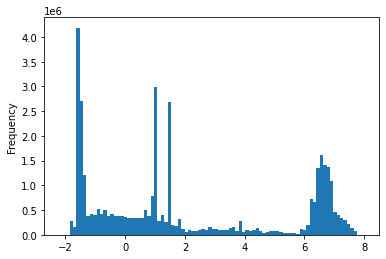

count    3.779235e+07
mean     2.037326e+00
std      3.237981e+00
min     -2.202500e+00
25%     -1.038500e+00
50%      1.033500e+00
75%      6.281500e+00
max      7.987500e+00
Name: cartesianZ, dtype: float64


In [6]:
dc  = get_distributions(df, "cartesianZ")

In [7]:
dc_hist = np.histogram(dc.values, bins=80)

In [8]:
hist_weights = dc_hist[0] / dc_hist[0].sum()

In [9]:
hist_centers = dc_hist[1]

In [10]:
sampled_data = np.random.choice(hist_centers[1:], size=10000, p = hist_weights)

In [11]:
gmm = GaussianMixture(5)
gmm = gmm.fit(sampled_data.reshape(-1,1))

In [12]:
floor_id = np.argmin(gmm.means_)
ceil_id = np.argmax(gmm.means_)

floor_cutoff = (gmm.means_[floor_id] + np.sqrt(gmm.covariances_[floor_id])*2).reshape(-1)[0]
ceil_cutoff = (gmm.means_[ceil_id] - np.sqrt(gmm.covariances_[ceil_id])*2).reshape(-1)[0]

In [13]:
floor_cutoff

-1.3288139414990408

In [14]:
ceil_cutoff

6.051516749018764

In [15]:
df = df[df.cartesianZ > floor_cutoff]
df = df[df.cartesianZ < ceil_cutoff-2]


In [16]:
df_plot = df[["cartesianX", "cartesianY", "intensity"]]

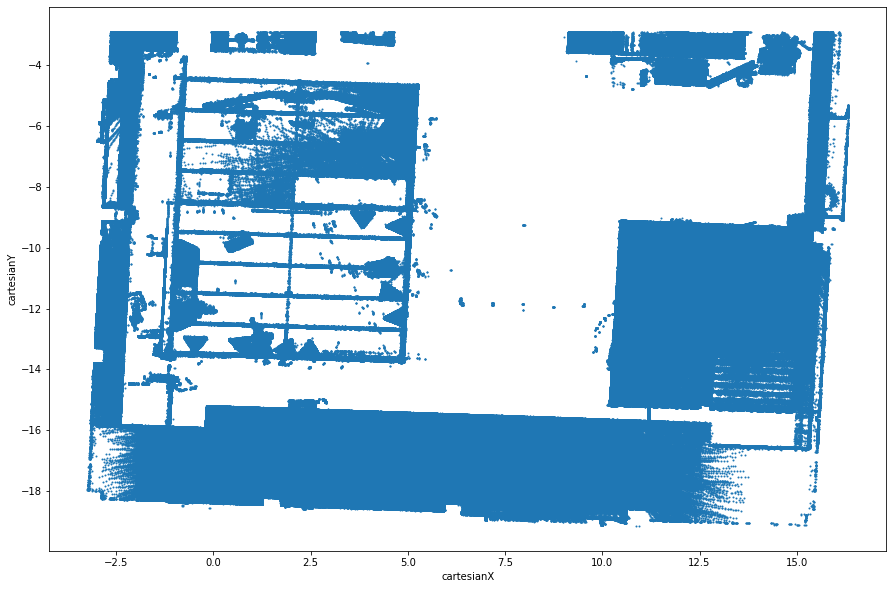

In [17]:
df_plot.plot.scatter("cartesianX", "cartesianY", s = 1, figsize=(15,10))
plt.show()

In [18]:
# Quick experiment to pixel

In [255]:
coords = df[["cartesianX", "cartesianY", "cartesianZ"]].copy()

minx = coords.cartesianX.min()
miny = coords.cartesianY.min()

coords.cartesianX -= minx
coords.cartesianY -= miny

coords.cartesianX *= 50 # 100
coords.cartesianX = coords.cartesianX.round().astype(np.int32)

coords.cartesianY *= 50 # 100
coords.cartesianY = coords.cartesianY.round().astype(np.int32)

maxx = coords.cartesianX.max()
maxy = coords.cartesianY.max()

In [256]:
matrix_bw_original = np.zeros([maxx+1, maxy+1], np.uint8)
matrix_bw_original[coords.cartesianX.values, coords.cartesianY.values] = 255

# Smooth:
img = matrix_bw_original

img = cv2.medianBlur(img, 3)

kernel = np.ones((3,3),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # erosion followed by dilation
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)  # dilation follows by erosion





# # Edge Detection
# # kernel = np.ones((9,9),np.uint8)
# # img = cv2.erode(img,kernel,iterations = 1)
# # img = cv2.Canny(img, 450,900, 3)
# # TO img

img = Image.fromarray(img, "L")
(width, height) = (img.width // 4, img.height // 4)
img = img.resize((width, height))
img.save('data/image.png')
img.show()

In [257]:
def process_img_(img, in_loop=True, only_postprocessing = False):
    
    if not in_loop:
        kernel = kernel = np.zeros((5,5),np.uint8)
        kernel[:,2] = 1
        img = cv2.dilate(img,kernel,iterations = 1)
        return img
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5)) 
    img = cv2.dilate(img,kernel,iterations = 1)
    
    # Diagonal
    kernel = np.zeros((3,3),np.uint8)
    for i in range(kernel.shape[0]):
        kernel[i, i] = 1
        kernel[-i-1, i] = 1
    img = cv2.dilate(img,kernel,iterations = 1)
    
    if only_postprocessing:
        return img
    
    if in_loop:
        kernel = np.ones((5,5),np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)  # dilation follows by erosion
        #img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # erosion followed by dilation
    return img


In [258]:
def _process_horizontal_slice(coords, maxx, maxy, z_step):
    matrix_bw_original = np.zeros([int(maxx+1), int(maxy+1)], np.uint8)
    matrix_bw_original[coords.cartesianX.values, coords.cartesianY.values] = 255
    # Smooth:
    img = matrix_bw_original
    
    # Horizontal and Vertical
    img = process_img_(img)
    img_ = Image.fromarray(img, "L")
    (width, height) = (img_.width // 4, img_.height // 4)
    img_ = img_.resize((width, height))
    img_.save(f'data/cuts/image_{z_step}.png')
    return img

In [259]:
def process_3d(all_data: pd.DataFrame, step_z_in_m=0.1):
    # get startx, start y coords

    coords = all_data.copy()
    
    # Pixel per CM # TODO check this please Todor is being stupid
    coords.cartesianX *= 100
    coords.cartesianX = coords.cartesianX.round().astype(np.int32)
    coords.cartesianY *= 100
    coords.cartesianY = coords.cartesianY.round().astype(np.int32)

    
    minx = coords.cartesianX.min()
    miny = coords.cartesianY.min()
    
    coords.cartesianX -= minx
    coords.cartesianY -= miny
    
    maxx = coords.cartesianX.max()
    maxy = coords.cartesianY.max()
    
    min_max_dict = {}
    min_max_dict["minx"] = minx
    min_max_dict["miny"] = miny
    min_max_dict["maxx"] = maxx
    min_max_dict["maxy"] = maxy
    
        
    cuts = []
    cuts_z_coord = []
    
    range_z = coords.cartesianZ.max() - coords.cartesianZ.min() 
    steps_z = int(np.ceil(range_z / step_z_in_m))
    
    current_z = coords.cartesianZ.min()
    
    for step in tqdm(range(steps_z)):
        upper = current_z + step_z_in_m
        
        # Get data
        cuts.append((coords[(current_z <= coords.cartesianZ) & (coords.cartesianZ < upper)])[["cartesianX", "cartesianY"]].copy())
        cuts_z_coord.append((current_z + upper)/2)
        
        
        current_z  = upper
    
    
    img_list  = Parallel(n_jobs=2)(delayed(_process_horizontal_slice)(cuts[int(i)], maxx, maxy, int(i)) for i in tqdm(range(steps_z)))
    
    return min_max_dict, cuts, cuts_z_coord, img_list
    


In [260]:
min_max_dict, cuts, cuts_z_coord, img_list = process_3d(df[["cartesianX", "cartesianY", "cartesianZ"]].copy())

100%|██████████| 54/54 [00:01<00:00, 33.75it/s]


In [261]:
d3_img = np.stack(img_list, axis=0)

In [262]:
for i in tqdm(range(d3_img.shape[1])): # move along x
    img = d3_img[:,i,:]
    img = process_img_(img, in_loop=False)
    d3_img[:,i,:]  = img

for j in tqdm(range(d3_img.shape[2])): # move along y
    img = d3_img[:,:,j]
    img = process_img_(img, in_loop=False)
    d3_img[:,:,j]  = img
    
for z in tqdm(range(d3_img.shape[0])): # move along z
    img = d3_img[z,:,:]
    #img = process_img_(img, only_postprocessing=True)
    d3_img[z,:,:]  = img
    # save final cuts
    img_ = Image.fromarray(img, "L")
    (width, height) = (img_.width // 4, img_.height // 4)
    img_ = img_.resize((width, height))
    img_.save(f'data/postprocessed_cuts/image_{z}.png')



100%|██████████| 54/54 [00:01<00:00, 42.68it/s]


In [267]:
coords3d = np.where(d3_img>250)

In [268]:
coords3d = np.hstack([coords3d[1].reshape(-1,1), coords3d[2].reshape(-1,1), coords3d[0].reshape(-1,1)])

In [270]:
coords3d.shape

(19299942, 3)

In [ ]:
clust = hdbscan.HDBSCAN()
clust.fit(coords3d)